In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
import matplotlib.pyplot as plt

In [ ]:
# Parâmetros
symbol = 'MELI'  # Exemplo de símbolo
start_date = '2020-01-01'
end_date = '2024-01-01'
sequence_length = 60

# Baixar os dados históricos
print(f"Baixando dados para o símbolo {symbol} de {start_date} a {end_date}.")
df = yf.download(symbol, start=start_date, end=end_date)

# Verificando se os dados foram baixados com sucesso
if df.empty:
    print(f"Nenhum dado encontrado para o símbolo {symbol} entre {start_date} e {end_date}.")
else:
    print("Dados baixados com sucesso.")

[*********************100%***********************]  1 of 1 completed

Baixando dados para o símbolo MELI de 2020-01-01 a 2024-01-01.
Dados baixados com sucesso.


In [ ]:
df

Price,Close,High,Low,Open,Volume
Ticker,MELI,MELI,MELI,MELI,MELI
Date,,,,,
2020-01-02,610.190002,615.840027,576.940002,576.940002,589200
2020-01-03,607.799988,609.840027,600.059998,602.619995,320900
2020-01-06,606.549988,613.789978,601.000000,601.039978,209700
2020-01-07,625.000000,627.969971,604.739990,606.640015,480900
2020-01-08,633.440002,637.820007,624.549988,625.000000,334600
...,...,...,...,...,...
2023-12-22,1589.079956,1593.000000,1575.569946,1593.000000,301300
2023-12-26,1576.640015,1598.000000,1568.089966,1597.900024,191000


In [ ]:
# Mostrar informações básicas sobre o DataFrame
print("\nInformações do DataFrame:")
print(df.info())


Informações do DataFrame:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1006 entries, 2020-01-02 to 2023-12-29
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, MELI)   1006 non-null   float64
 1   (High, MELI)    1006 non-null   float64
 2   (Low, MELI)     1006 non-null   float64
 3   (Open, MELI)    1006 non-null   float64
 4   (Volume, MELI)  1006 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 47.2 KB
None


In [ ]:
# Estatísticas descritivas
print("\nEstatísticas descritivas:")
print(df.describe())


Estatísticas descritivas:
Price         Close         High          Low         Open        Volume
Ticker         MELI         MELI         MELI         MELI          MELI
count   1006.000000  1006.000000  1006.000000  1006.000000  1.006000e+03
mean    1185.337605  1209.575686  1160.672715  1186.197785  5.474474e+05
std      346.198930   348.891197   343.113646   347.775765  2.558005e+05
min      447.339996   460.959991   422.220001   445.470001  1.328000e+05
25%      922.904984   946.367477   903.384995   928.514984  3.676250e+05
50%     1196.650024  1221.724976  1173.059998  1196.510010  4.894500e+05
75%     1434.445038  1459.524994  1401.845001  1437.587494  6.537000e+05
max     1984.339966  2020.000000  1929.520020  2020.000000  2.359100e+06


In [ ]:

# Verificar se há valores nulos
print("\nVerificar valores nulos:")
print(df.isnull().sum())


Verificar valores nulos:
Price   Ticker
Close   MELI      0
High    MELI      0
Low     MELI      0
Open    MELI      0
Volume  MELI      0
dtype: int64


In [ ]:
# Visualizar a correlação entre as variáveis (no caso, apenas a coluna 'Close' existe, mas podemos expandir)
# Como estamos lidando com um único atributo 'Close', a matriz de correlação será trivial, mas vamos incluir de qualquer forma.
print("\nMatriz de correlação:")
print(df.corr())


Matriz de correlação:
Price             Close      High       Low      Open    Volume
Ticker             MELI      MELI      MELI      MELI      MELI
Price  Ticker                                                  
Close  MELI    1.000000  0.997718  0.998268  0.995254 -0.340206
High   MELI    0.997718  1.000000  0.997682  0.998279 -0.317614
Low    MELI    0.998268  0.997682  1.000000  0.997603 -0.356562
Open   MELI    0.995254  0.998279  0.997603  1.000000 -0.333196
Volume MELI   -0.340206 -0.317614 -0.356562 -0.333196  1.000000


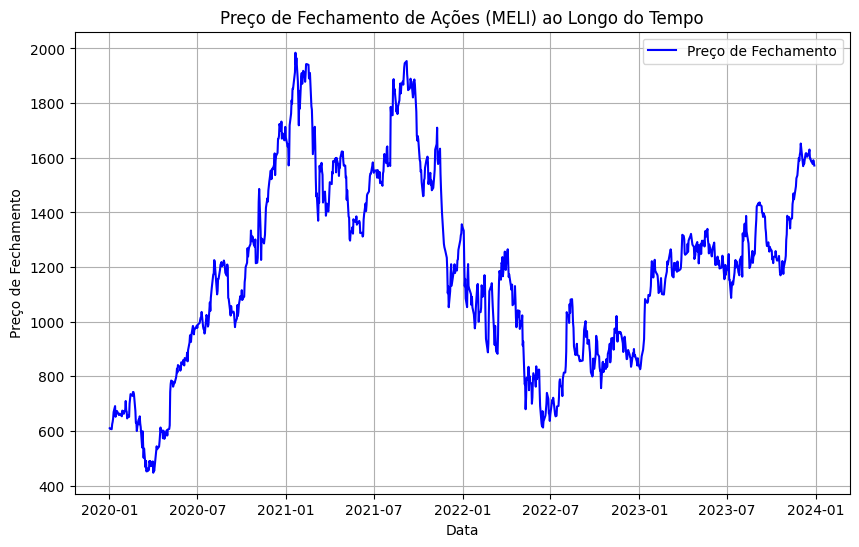

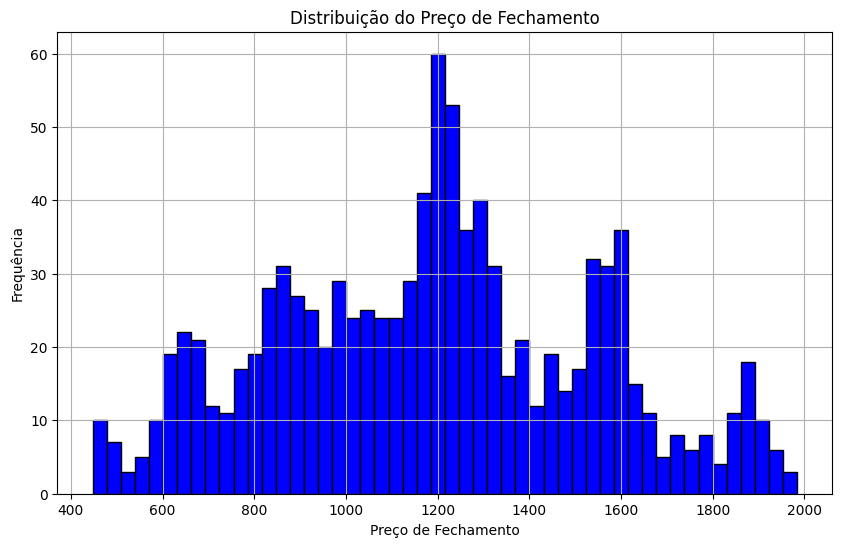

In [ ]:
# Análise exploratória do DataFrame df


# Plotando a série temporal de preços de fechamento
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Close'], label='Preço de Fechamento', color='blue')
plt.title(f'Preço de Fechamento de Ações ({symbol}) ao Longo do Tempo')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 6))
plt.hist(df['Close'], bins=50, color='blue', edgecolor='black')
plt.title('Distribuição do Preço de Fechamento')
plt.xlabel('Preço de Fechamento')
plt.ylabel('Frequência')
plt.grid(True)
plt.show()


In [ ]:
#Criar novo df
dfr=df

**Modelo LSTM (Long Short-Term Memory): Memórias de longo prazo** - Muitas dimensões

In [ ]:

#1. Modelo LSTM (55 épocas) com Dropout (regularização) após cada camada: Evitar overfitting (desativando aleatoriamente uma proporção de neurônios em cada iteração).
#Otimização Adam: gradiente descendente adaptativo (vetor). Minimizar funções de perda. ir em sua direção oposta.
# Selecionar apenas a coluna 'Close'
df = dfr[['Close']]

# Normalizar os dados
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df)

# Criar as sequências para o modelo LSTM
X, y = [], []
for i in range(sequence_length, len(df_scaled)):
    X.append(df_scaled[i-sequence_length:i, 0]) #coluna Close
    y.append(df_scaled[i, 0])

X = np.array(X) # Lista de sequências (amostras da coluna Close)
y = np.array(y) #Target

# Dividir os dados em treino e validação (80% treino, 20% validação)
train_size = int(len(X) * 0.8)
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

# Ajustar a forma dos dados para o LSTM
X_train = X_train.reshape(X_train.shape[0], #Número de amostras
                          X_train.shape[1], #Comprimento das sequências
                          1)#1 variável (close)
X_val = X_val.reshape(X_val.shape[0],
                      X_val.shape[1],
                      1)

# Criação do modelo LSTM
model = Sequential()
#Camada 1
model.add(LSTM(units=150, return_sequences=True, #A camada retornará a sequência completa (em vez de apenas a última saída) para a próxima camada
               input_shape=(sequence_length, 1)))
model.add(Dropout(0.2))

#Camada 2
model.add(LSTM(units=150, return_sequences=False))
model.add(Dropout(0.2))

#Camada de saída
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Treinamento do modelo
print("Iniciando o treinamento do modelo LSTM.")
model.fit(X_train, y_train, epochs=55, batch_size=32, validation_data=(X_val, y_val), verbose=1)
print("Treinamento concluído.")

# Fazer previsões no conjunto de validação
y_pred_scaled = model.predict(X_val)

# Inverter a normalização para os valores previstos e reais
y_pred = scaler.inverse_transform(y_pred_scaled)
y_val_inv = scaler.inverse_transform(y_val.reshape(-1, 1))




Iniciando o treinamento do modelo LSTM.
Epoch 1/55


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 243ms/step - loss: 0.0843 - val_loss: 0.0059
Epoch 2/55
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 221ms/step - loss: 0.0068 - val_loss: 0.0019
Epoch 3/55
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 212ms/step - loss: 0.0046 - val_loss: 0.0016
Epoch 4/55
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 267ms/step - loss: 0.0039 - val_loss: 0.0015
Epoch 5/55
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 221ms/step - loss: 0.0046 - val_loss: 0.0016
Epoch 6/55
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 222ms/step - loss: 0.0040 - val_loss: 0.0030
Epoch 7/55
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 212ms/step - loss: 0.0047 - val_loss: 0.0013
Epoch 8/55
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 281ms/step - loss: 0.0034 - val_loss: 0.0037
Epoch 9/55
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 215ms/step - loss: 0.0038 - val_loss: 0.0015
Epoch 10/55
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 284ms/step - loss: 0.0038 - val_loss: 0.0012
Epoch 11/55
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 289ms/step - loss: 0.0035 - val_loss: 0.0021
Epoch 12/55
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 225ms/step - lo

In [ ]:

# Avaliar o modelo
mae = mean_absolute_error(y_val_inv, y_pred)# (Mean Absolute Error): Erro absoluto médio: Média das diferenças absolutas entre os valores reais e previstos
rmse = math.sqrt(mean_squared_error(y_val_inv, y_pred))# (Root Mean Squared Error): Raiz do erro quadrático médio: Penaliza erros maiores
mape = np.mean(np.abs((y_val_inv - y_pred) / y_val_inv)) * 100 #(Mean Absolute Percentage Error): Erro percentual absoluto médio: Diferença entre os valores reais e previstos

# Exibir as métricas de avaliação
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4f}%")



MAE: 30.2046
RMSE: 38.4345
MAPE: 2.2897%


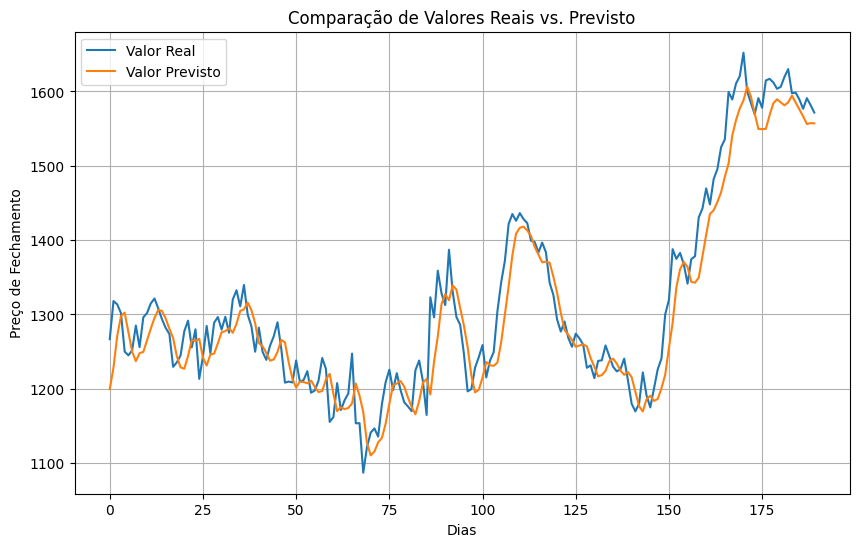

In [ ]:
# Exibir os gráficos de comparação entre valores reais e previstos
plt.figure(figsize=(10, 6))
plt.plot(y_val_inv, label='Valor Real')
plt.plot(y_pred, label='Valor Previsto')
plt.title(f'Comparação de Valores Reais vs. Previsto')
plt.xlabel('Dias')
plt.ylabel('Preço de Fechamento')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
#Testes
#Aumento do número de unidades nas camadas LSTM para 100 (número de neurônios)
#Diminuição do número de épocas: Evita overfitting



In [ ]:
!pip install scikit-learn

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

# 2. Regressão Linear (possível overffiting)


# Modelo de Regressão Linear
regressor_linear = LinearRegression()
regressor_linear.fit(X_train.reshape(X_train.shape[0], X_train.shape[1]), y_train)
y_pred_linear = regressor_linear.predict(X_val.reshape(X_val.shape[0], X_val.shape[1]))

# Inverter a normalização para os valores previstos
y_pred_linear = scaler.inverse_transform(y_pred_linear.reshape(-1, 1))

# Avaliação da Regressão Linear
mae_linear = mean_absolute_error(y_val_inv, y_pred_linear)
rmse_linear = math.sqrt(mean_squared_error(y_val_inv, y_pred_linear))
mape_linear = np.mean(np.abs((y_val_inv - y_pred_linear) / y_val_inv)) * 100

print(f"Linear Regression - MAE: {mae_linear:.4f}, RMSE: {rmse_linear:.4f}, MAPE: {mape_linear:.4f}%")




Linear Regression - MAE: 25.5243, RMSE: 33.1631, MAPE: 1.9735%


In [ ]:

# 3. Regressão Ridge


# Modelo de Regressão Ridge
regressor_ridge = Ridge(alpha=1.0)
regressor_ridge.fit(X_train.reshape(X_train.shape[0], X_train.shape[1]), y_train)
y_pred_ridge = regressor_ridge.predict(X_val.reshape(X_val.shape[0], X_val.shape[1]))
y_pred_ridge = scaler.inverse_transform(y_pred_ridge.reshape(-1, 1))

# Avaliação da Regressão Ridge
mae_ridge = mean_absolute_error(y_val_inv, y_pred_ridge)
rmse_ridge = math.sqrt(mean_squared_error(y_val_inv, y_pred_ridge))
mape_ridge = np.mean(np.abs((y_val_inv - y_pred_ridge) / y_val_inv)) * 100

print(f"Ridge Regression - MAE: {mae_ridge:.4f}, RMSE: {rmse_ridge:.4f}, MAPE: {mape_ridge:.4f}%")

Ridge Regression - MAE: 27.3796, RMSE: 34.8354, MAPE: 2.0982%


In [ ]:

# 4. Regressão Lasso

regressor_lasso = Lasso(alpha=0.1)
regressor_lasso.fit(X_train.reshape(X_train.shape[0], X_train.shape[1]), y_train)
y_pred_lasso = regressor_lasso.predict(X_val.reshape(X_val.shape[0], X_val.shape[1]))
y_pred_lasso = scaler.inverse_transform(y_pred_lasso.reshape(-1, 1))

# Avaliação da Regressão Lasso
mae_lasso = mean_absolute_error(y_val_inv, y_pred_lasso)
rmse_lasso = math.sqrt(mean_squared_error(y_val_inv, y_pred_lasso))
mape_lasso = np.mean(np.abs((y_val_inv - y_pred_lasso) / y_val_inv)) * 100

print(f"Lasso Regression - MAE: {mae_lasso:.4f}, RMSE: {rmse_lasso:.4f}, MAPE: {mape_lasso:.4f}%")

Lasso Regression - MAE: 126.3912, RMSE: 178.2241, MAPE: 8.8393%


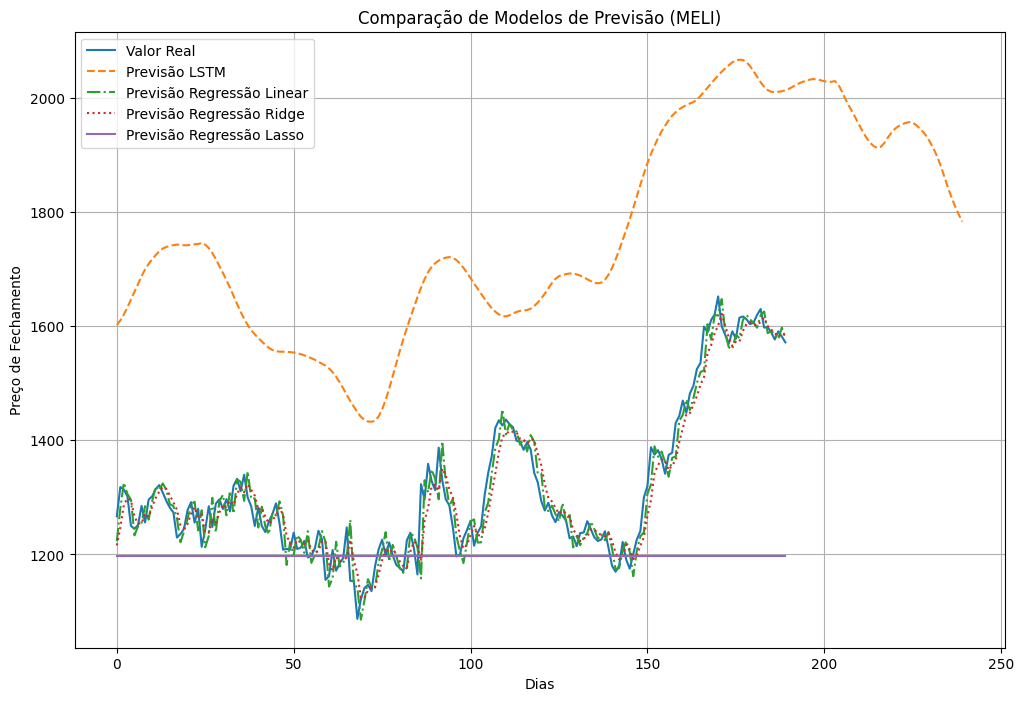

In [ ]:

# Gráfico das previsões comparando os modelos
plt.figure(figsize=(12, 8))
plt.plot(y_val_inv, label='Valor Real')
plt.plot(y_pred_lstm, label='Previsão LSTM', linestyle='--')
plt.plot(y_pred_linear, label='Previsão Regressão Linear', linestyle='-.')
plt.plot(y_pred_ridge, label='Previsão Regressão Ridge', linestyle=':')
plt.plot(y_pred_lasso, label='Previsão Regressão Lasso', linestyle='-')
plt.title(f'Comparação de Modelos de Previsão ({symbol})')
plt.xlabel('Dias')
plt.ylabel('Preço de Fechamento')
plt.legend()
plt.grid(True)
plt.show()

Linear Regression (Treinamento) - MAE: 1196.8752, RMSE: 1247.8035, MAPE: 99.9552%
Linear Regression (Validação) - MAE: 1315.0790, RMSE: 1321.8111, MAPE: 99.9568%


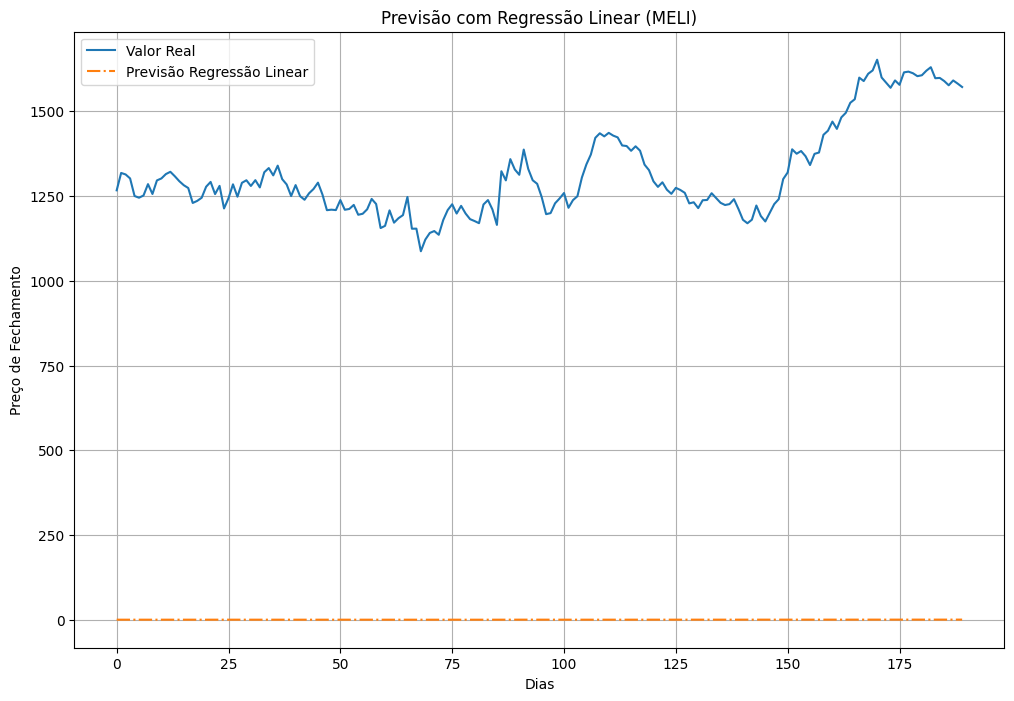

In [ ]:
#Avaliando o modelo de Regressão Linear

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import math
import matplotlib.pyplot as plt


# Modelo de Regressão Linear
regressor_linear = LinearRegression()

# Treinamento do modelo de Regressão Linear
regressor_linear.fit(X_train.reshape(X_train.shape[0], X_train.shape[1]), y_train)

# Previsões no conjunto de treino
y_pred_train_linear = regressor_linear.predict(X_train.reshape(X_train.shape[0], X_train.shape[1]))

# Previsões no conjunto de validação
y_pred_linear = regressor_linear.predict(X_val.reshape(X_val.shape[0], X_val.shape[1]))

# Inverter a normalização para os valores de treino (y_train) - Desnormalizar
y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
y_val_inv = scaler.inverse_transform(y_val.reshape(-1, 1))

# Avaliação da Regressão Linear nos dois conjuntos (treinamento e validação)
mae_train_linear = mean_absolute_error(y_train_inv, y_pred_train_linear)
rmse_train_linear = math.sqrt(mean_squared_error(y_train_inv, y_pred_train_linear))
mape_train_linear = np.mean(np.abs((y_train_inv - y_pred_train_linear) / y_train_inv)) * 100

mae_linear = mean_absolute_error(y_val_inv, y_pred_linear)
rmse_linear = math.sqrt(mean_squared_error(y_val_inv, y_pred_linear))
mape_linear = np.mean(np.abs((y_val_inv - y_pred_linear) / y_val_inv)) * 100

# Exibir as métricas para o treino e validação
print(f"Linear Regression (Treinamento) - MAE: {mae_train_linear:.4f}, RMSE: {rmse_train_linear:.4f}, MAPE: {mape_train_linear:.4f}%")
print(f"Linear Regression (Validação) - MAE: {mae_linear:.4f}, RMSE: {rmse_linear:.4f}, MAPE: {mape_linear:.4f}%")


# Gráfico das previsões da Regressão Linear comparando os valores reais e previstos

plt.figure(figsize=(12, 8))
plt.plot(y_val_inv, label='Valor Real')
plt.plot(y_pred_linear, label='Previsão Regressão Linear', linestyle='-.')
plt.title(f'Previsão com Regressão Linear ({symbol})')
plt.xlabel('Dias')
plt.ylabel('Preço de Fechamento')
plt.legend()
plt.grid(True)
plt.show()


**Se houver uma grande discrepância entre essas métricas nos dois conjuntos (treinamento e validação), isso pode indicar que o modelo está overfitting.**

[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Dados baixados com sucesso.
Epoch 1/55
30/30 ━━━━━━━━━━━━━━━━━━━━ 25s 602ms/step - loss: 0.0532 - val_loss: 0.0113
Epoch 2/55
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 213ms/step - loss: 0.0049 - val_loss: 0.0029
Epoch 3/55
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 268ms/step - loss: 0.0039 - val_loss: 0.0032
Epoch 4/55
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 264ms/step - loss: 0.0041 - val_loss: 0.0021
Epoch 5/55
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 235ms/step - loss: 0.0036 - val_loss: 0.0041
Epoch 6/55
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 219ms/step - loss: 0.0034 - val_loss: 0.0027
Epoch 7/55
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 223ms/step - loss: 0.0032 - val_loss: 0.0018
Epoch 8/55
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 225ms/step - loss: 0.0033 - val_loss: 0.0019
Epoch 9/55
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 264ms/step - loss: 0.0032 - val_loss: 0.0016
Epoch 10/55
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 245ms/step - loss: 0.0029 - val_loss: 0.0016
Epoch 11/55
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 230ms/step - loss: 0.0027 - val_loss: 0.0020
Epoch 12/55
30/30

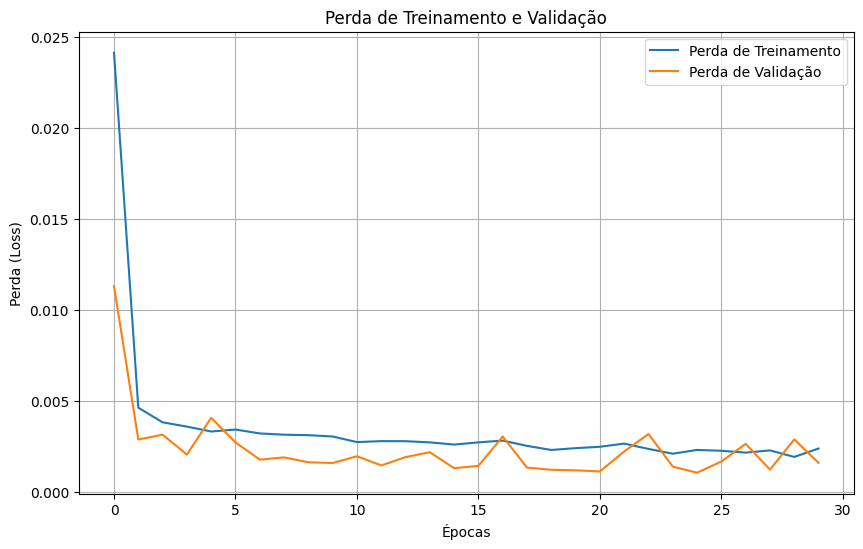

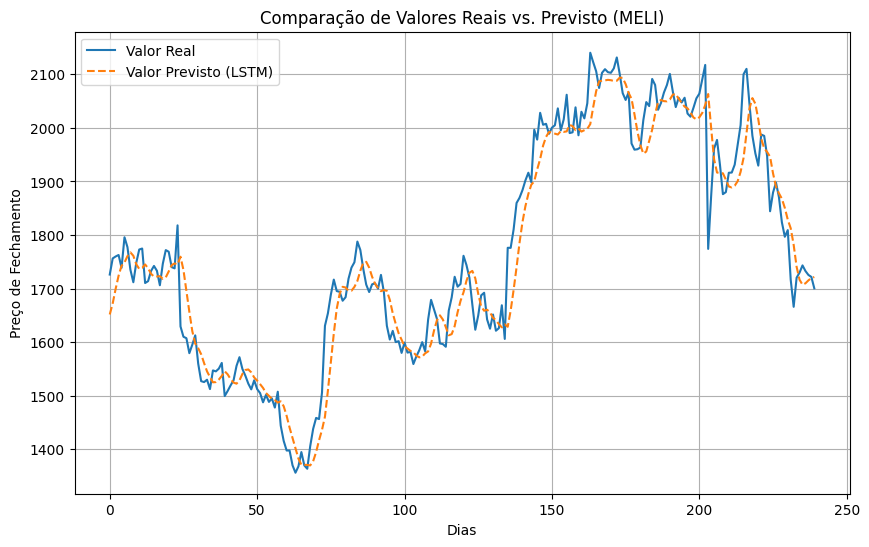

In [ ]:
#Melhor Desempenho LSTM com 55 épocas e 150 unidades cada camada



# Carregar os dados históricos
symbol = 'MELI'  # Exemplo de símbolo
start_date = '2020-01-01'
end_date = '2025-01-01'

df = yf.download(symbol, start=start_date, end=end_date)

# Verificando se os dados foram baixados com sucesso
if df.empty:
    print(f"Nenhum dado encontrado para o símbolo {symbol} entre {start_date} e {end_date}.")
else:
    print("Dados baixados com sucesso.")

# Selecionar apenas a coluna 'Close'
df = df[['Close']]

# Normalizar os dados
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df)

# Criar as sequências para o modelo LSTM
sequence_length = 60
X, y = [], []
for i in range(sequence_length, len(df_scaled)):
    X.append(df_scaled[i-sequence_length:i, 0])
    y.append(df_scaled[i, 0])

X = np.array(X)
y = np.array(y)

# Dividir os dados em treino e validação (80% treino, 20% validação)
train_size = int(len(X) * 0.8)
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

# Ajustar a forma dos dados para o LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)


# 1. Modelo LSTM com Early Stopping (ao final de cada época é calculada a precisão)


# Definir o modelo LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(units=150, return_sequences=True, input_shape=(sequence_length, 1)))
model_lstm.add(Dropout(0.3)) #desliga 30%
model_lstm.add(LSTM(units=150, return_sequences=False))
model_lstm.add(Dropout(0.3))
model_lstm.add(Dense(units=1))#1 neurônio
model_lstm.compile(optimizer='adam', loss='mean_squared_error') #Ajusta os pesos

# Definir o callback de Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Treinamento do modelo LSTM com Early Stopping
history = model_lstm.fit(X_train, y_train, epochs=55, batch_size=32, validation_data=(X_val, y_val),
                         verbose=1, callbacks=[early_stopping])

# bach_size = número de amostras que serão processadas antes de atualizar os pesos


# 2. Avaliação do Modelo LSTM


# Fazer previsões no conjunto de validação
y_pred_lstm_scaled = model_lstm.predict(X_val)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm_scaled)
y_val_inv = scaler.inverse_transform(y_val.reshape(-1, 1))

# Métricas de Avaliação
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

mae_lstm = mean_absolute_error(y_val_inv, y_pred_lstm)
rmse_lstm = math.sqrt(mean_squared_error(y_val_inv, y_pred_lstm))
mape_lstm = np.mean(np.abs((y_val_inv - y_pred_lstm) / y_val_inv)) * 100

print(f"LSTM - MAE: {mae_lstm:.4f}, RMSE: {rmse_lstm:.4f}, MAPE: {mape_lstm:.4f}%")




# Gráfico da perda de treinamento e validação
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Perda de Treinamento')
plt.plot(history.history['val_loss'], label='Perda de Validação')
plt.title('Perda de Treinamento e Validação')
plt.xlabel('Épocas')
plt.ylabel('Perda (Loss)')
plt.legend()
plt.grid(True)
plt.show()

# Gráfico de comparação entre valores reais e previstos
plt.figure(figsize=(10, 6))
plt.plot(y_val_inv, label='Valor Real')
plt.plot(y_pred_lstm, label='Valor Previsto (LSTM)', linestyle='--')
plt.title(f'Comparação de Valores Reais vs. Previsto ({symbol})')
plt.xlabel('Dias')
plt.ylabel('Preço de Fechamento')
plt.legend()
plt.grid(True)
plt.show()


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Dados baixados com sucesso.
Epoch 1/55
96/96 ━━━━━━━━━━━━━━━━━━━━ 18s 127ms/step - loss: 12.6721 - val_loss: 0.2954
Epoch 2/55
96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 116ms/step - loss: 0.1294 - val_loss: 0.0258
Epoch 3/55
96/96 ━━━━━━━━━━━━━━━━━━━━ 20s 113ms/step - loss: 0.0152 - val_loss: 0.0130
Epoch 4/55
96/96 ━━━━━━━━━━━━━━━━━━━━ 21s 122ms/step - loss: 0.0153 - val_loss: 0.0132
Epoch 5/55
96/96 ━━━━━━━━━━━━━━━━━━━━ 21s 124ms/step - loss: 0.0156 - val_loss: 0.0133
Epoch 6/55
96/96 ━━━━━━━━━━━━━━━━━━━━ 19s 112ms/step - loss: 0.0155 - val_loss: 0.0407
Epoch 7/55
96/96 ━━━━━━━━━━━━━━━━━━━━ 21s 122ms/step - loss: 0.0138 - val_loss: 0.0114
Epoch 8/55
96/96 ━━━━━━━━━━━━━━━━━━━━ 20s 122ms/step - loss: 0.0112 - val_loss: 0.0178
Epoch 9/55
96/96 ━━━━━━━━━━━━━━━━━━━━ 19s 110ms/step - loss: 0.0105 - val_loss: 0.0143
Epoch 10/55
96/96 ━━━━━━━━━━━━━━━━━━━━ 21s 121ms/step - loss: 0.0113 - val_loss: 0.0156
Epoch 11/55
96/96 ━━━━━━━━━━━━━━━━━━━━ 21s 123ms/step - loss: 0.0113 - val_loss: 0.0253
Epoch 12/55


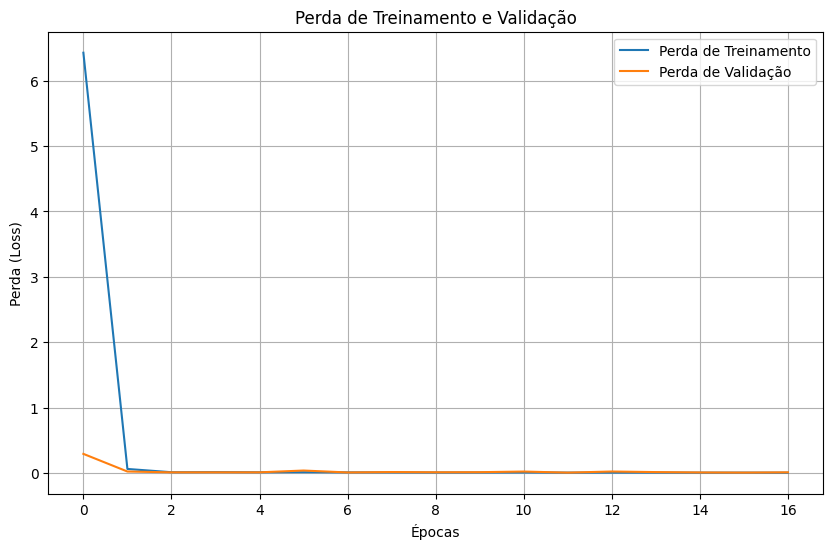

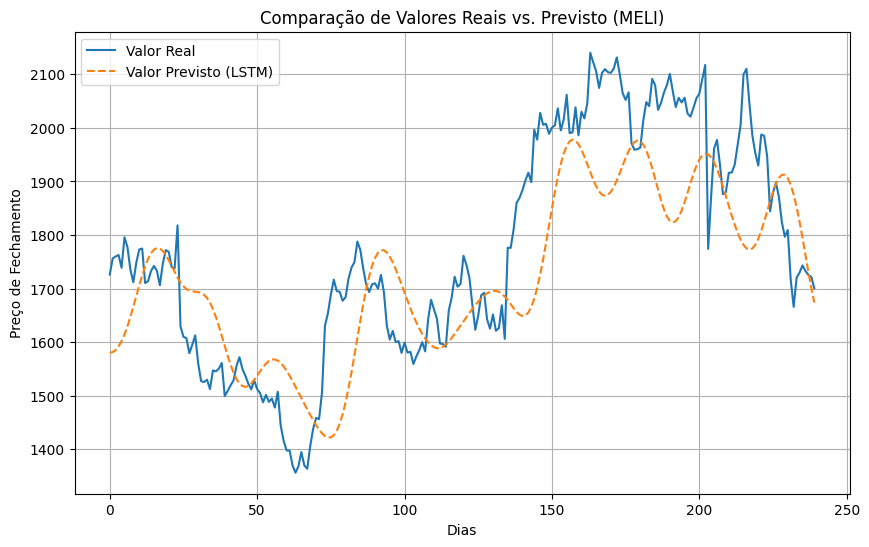

In [ ]:
#Alterações Importantes:
#L2 Regularization: O kernel_regularizer=l2(0.01) foi adicionado nas camadas LSTM para ajudar a regularizar o modelo e evitar o overfitting. Risco de underfitting
#Camada Densa Adicional: Foi adicionada uma camada densa de 50 unidades após as camadas LSTM para ajustar melhor as saídas antes da camada final.

#EarlyStopping: O patience foi ajustado para 10, permitindo mais épocas de aprendizado antes da interrupção.

import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Carregar os dados históricos
symbol = 'MELI'  # Exemplo de símbolo
start_date = '2020-01-01'
end_date = '2025-01-01'

df = yf.download(symbol, start=start_date, end=end_date)

# Verificando se os dados foram baixados com sucesso
if df.empty:
    print(f"Nenhum dado encontrado para o símbolo {symbol} entre {start_date} e {end_date}.")
else:
    print("Dados baixados com sucesso.")

# Selecionar apenas a coluna 'Close'
df = df[['Close']]

# Normalizar os dados
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df)

# Criar as sequências para o modelo LSTM
sequence_length = 60
X, y = [], []
for i in range(sequence_length, len(df_scaled)):
    X.append(df_scaled[i-sequence_length:i, 0])
    y.append(df_scaled[i, 0])

X = np.array(X)
y = np.array(y)

# Dividir os dados em treino e validação (80% treino, 20% validação)
train_size = int(len(X) * 0.8)
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

# Ajustar a forma dos dados para o LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)


# 1. Modelo LSTM Ajustado com L2 Regularization


# Definir o modelo LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(units=150, return_sequences=True, input_shape=(sequence_length, 1),
                    kernel_regularizer=l2(0.1)))  # L2 Regularization
model_lstm.add(Dropout(0.3))
model_lstm.add(LSTM(units=150, return_sequences=False, kernel_regularizer=l2(0.1)))  # L2 Regularization
model_lstm.add(Dropout(0.3))

# Adicionar uma camada densa para ajustar a saída
model_lstm.add(Dense(units=50, activation='relu'))  # Camada densa adicional
model_lstm.add(Dense(units=1))  # Camada de saída
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Definir o callback de Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Treinamento do modelo LSTM com Early Stopping
history = model_lstm.fit(X_train, y_train, epochs=55, batch_size=10, validation_data=(X_val, y_val),
                         verbose=1, callbacks=[early_stopping])


# 2. Avaliação do Modelo LSTM


# Fazer previsões no conjunto de validação
y_pred_lstm_scaled = model_lstm.predict(X_val)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm_scaled)
y_val_inv = scaler.inverse_transform(y_val.reshape(-1, 1))

# Métricas de Avaliação
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

mae_lstm = mean_absolute_error(y_val_inv, y_pred_lstm)
rmse_lstm = math.sqrt(mean_squared_error(y_val_inv, y_pred_lstm))
mape_lstm = np.mean(np.abs((y_val_inv - y_pred_lstm) / y_val_inv)) * 100

print(f"LSTM - MAE: {mae_lstm:.4f}, RMSE: {rmse_lstm:.4f}, MAPE: {mape_lstm:.4f}%")



# Gráfico da perda de treinamento e validação
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Perda de Treinamento')
plt.plot(history.history['val_loss'], label='Perda de Validação')
plt.title('Perda de Treinamento e Validação')
plt.xlabel('Épocas')
plt.ylabel('Perda (Loss)')
plt.legend()
plt.grid(True)
plt.show()

# Gráfico de comparação entre valores reais e previstos
plt.figure(figsize=(10, 6))
plt.plot(y_val_inv, label='Valor Real')
plt.plot(y_pred_lstm, label='Valor Previsto (LSTM)', linestyle='--')
plt.title(f'Comparação de Valores Reais vs. Previsto ({symbol})')
plt.xlabel('Dias')
plt.ylabel('Preço de Fechamento')
plt.legend()
plt.grid(True)
plt.show()


Regularização L2: Usada para evitar overfitting, penalizando os pesos maiores durante o treinamento.

Early Stopping: Técnica que interrompe o treinamento quando a perda de validação começa a aumentar, evitando o overfitting.

In [ ]:
!pip install shap


In [ ]:
import shap
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
import math

# Carregar os dados históricos
symbol = 'MELI'  # Exemplo de símbolo
start_date = '2020-01-01'
end_date = '2025-01-01'
df = yf.download(symbol, start=start_date, end=end_date)

# Verificando se os dados foram baixados com sucesso
if df.empty:
    print(f"Nenhum dado encontrado para o símbolo {symbol} entre {start_date} e {end_date}.")
else:
    print("Dados baixados com sucesso.")

# Selecionar as colunas 'Close', 'Open', 'High', 'Low', 'Volume' para treino
df = df[['Close', 'Open', 'High', 'Low', 'Volume']]

# Normalizar os dados
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df)

# Criar as sequências para o modelo LSTM
sequence_length = 60
X, y = [], []

for i in range(sequence_length, len(df_scaled)):
    X.append(df_scaled[i-sequence_length:i, :])  # Usando todas as colunas
    y.append(df_scaled[i, 0])  # Prevendo a coluna 'Close'

X = np.array(X)
y = np.array(y)

# Dividir os dados em treino e validação (80% treino, 20% validação)
train_size = int(len(X) * 0.8)
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

# Ajustar a forma dos dados para o LSTM (sequências de dados multivariados)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])  # (samples, time_steps, features)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2])  # (samples, time_steps, features)

# ========================
# 1. Modelo LSTM Ajustado
# ========================
model_lstm = Sequential()
model_lstm.add(LSTM(units=150, return_sequences=True, input_shape=(sequence_length, X_train.shape[2]),
                    kernel_regularizer=l2(0.01)))  # L2 Regularization
model_lstm.add(Dropout(0.4))  # Dropout de 40%
model_lstm.add(LSTM(units=150, return_sequences=False, kernel_regularizer=l2(0.01)))  # L2 Regularization
model_lstm.add(Dropout(0.4))  # Dropout de 40%
model_lstm.add(Dense(units=1))  # Camada de saída
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Definir o callback de Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Treinamento do modelo LSTM com Early Stopping
history = model_lstm.fit(X_train, y_train, epochs=55, batch_size=15, validation_data=(X_val, y_val),
                         verbose=1, callbacks=[early_stopping])

# ============================
# 2. Avaliação do Modelo LSTM
# ============================
y_pred_lstm_scaled = model_lstm.predict(X_val)
y_pred_lstm = scaler.inverse_transform(np.concatenate((y_pred_lstm_scaled, np.zeros((y_pred_lstm_scaled.shape[0], X_val.shape[2]-1))), axis=1))[:, 0]
y_val_inv = scaler.inverse_transform(np.concatenate((y_val.reshape(-1, 1), np.zeros((y_val.shape[0], X_val.shape[2]-1))), axis=1))[:, 0]

# Métricas de Avaliação
mae_lstm = mean_absolute_error(y_val_inv, y_pred_lstm)
rmse_lstm = math.sqrt(mean_squared_error(y_val_inv, y_pred_lstm))
mape_lstm = np.mean(np.abs((y_val_inv - y_pred_lstm) / y_val_inv)) * 100

print(f"LSTM - MAE: {mae_lstm:.4f}, RMSE: {rmse_lstm:.4f}, MAPE: {mape_lstm:.4f}%")

# ============================
# 3. Explicação de SHAP
# ============================
# Garantir que a entrada para o SHAP tenha a forma correta
X_train_2d = X_train.reshape((X_train.shape[0], -1))  # Flatten para 2D (samples, time_steps * features)

# Ajuste do explainer para SHAP
explainer = shap.KernelExplainer(model_lstm.predict, X_train_2d[:100])  # Usamos uma amostra pequena para acelerar
shap_values = explainer.shap_values(X_train_2d[:100])

# Gráfico de dependência de SHAP para visualizar a importância de cada variável
shap.summary_plot(shap_values, X_train_2d[:100], feature_names=df.columns)

# ============================
# 4. Gráficos de Desempenho
# ============================
# Gráfico da perda de treinamento e validação
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Perda de Treinamento')
plt.plot(history.history['val_loss'], label='Perda de Validação')
plt.title('Perda de Treinamento e Validação')
plt.xlabel('Épocas')
plt.ylabel('Perda (Loss)')
plt.legend()
plt.grid(True)
plt.show()

# Gráfico de comparação entre valores reais e previstos
plt.figure(figsize=(10, 6))
plt.plot(y_val_inv, label='Valor Real')
plt.plot(y_pred_lstm, label='Valor Previsto (LSTM)', linestyle='--')
plt.title(f'Comparação de Valores Reais vs. Previsto ({symbol})')
plt.xlabel('Dias')
plt.ylabel('Preço de Fechamento')
plt.legend()
plt.grid(True)
plt.show()


[*********************100%***********************]  1 of 1 completed

Dados baixados com sucesso.
Epoch 1/55



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 154ms/step - loss: 1.6742 - val_loss: 0.2580
Epoch 2/55
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 176ms/step - loss: 0.1620 - val_loss: 0.0362
Epoch 3/55
64/64 ━━━━━━━━━━━━━━━━━━━━ 19s 147ms/step - loss: 0.0294 - val_loss: 0.0141
Epoch 4/55
64/64 ━━━━━━━━━━━━━━━━━━━━ 10s 158ms/step - loss: 0.0156 - val_loss: 0.0109
Epoch 5/55
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - loss: 0.0115 - val_loss: 0.0099
Epoch 6/55
64/64 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - loss: 0.0109 - val_loss: 0.0096
Epoch 7/55
64/64 ━━━━━━━━━━━━━━━━━━━━ 10s 150ms/step - loss: 0.0086 - val_loss: 0.0102
Epoch 8/55
64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 217ms/step - loss: 0.0093 - val_loss: 0.0073
Epoch 9/55
64/64 ━━━━━━━━━━━━━━━━━━━━ 16s 144ms/step - loss: 0.0092 - val_loss: 0.0067
Epoch 10/55
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - loss: 0.0084 - val_loss: 0.0083
Epoch 11/55
64/64 ━━━━━━━━━━━━━━━━━━━━ 10s 150ms/step - loss: 0.0082 - val_loss: 0.0098
Epoch 12/55
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 200ms/step 

ValueError: Exception encountered when calling Sequential.call().

[1mCannot take the length of shape with unknown rank.[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
  • training=False
  • mask=None

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Dados baixados com sucesso.
Dimensões de X (dados de entrada): (1198, 60, 5)
Dimensões de y (rótulos): (1198,)
Dimensões de X_train: (958, 60, 5)
Dimensões de X_val: (240, 60, 5)
Dimensões de X_train após reshape: (958, 60, 5)
Dimensões de X_val após reshape: (240, 60, 5)
Epoch 1/55
64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 160ms/step - loss: 1.6575 - val_loss: 0.2399
Epoch 2/55
64/64 ━━━━━━━━━━━━━━━━━━━━ 21s 178ms/step - loss: 0.1502 - val_loss: 0.0292
Epoch 3/55
64/64 ━━━━━━━━━━━━━━━━━━━━ 11s 178ms/step - loss: 0.0271 - val_loss: 0.0231
Epoch 4/55
64/64 ━━━━━━━━━━━━━━━━━━━━ 11s 168ms/step - loss: 0.0140 - val_loss: 0.0115
Epoch 5/55
64/64 ━━━━━━━━━━━━━━━━━━━━ 18s 136ms/step - loss: 0.0118 - val_loss: 0.0074
Epoch 6/55
64/64 ━━━━━━━━━━━━━━━━━━━━ 11s 157ms/step - loss: 0.0098 - val_loss: 0.0132
Epoch 7/55
64/64 ━━━━━━━━━━━━━━━━━━━━ 10s 157ms/step - loss: 0.0089 - val_loss: 0.0205
Epoch 8/55
64/64 ━━━━━━━━━━━━━━━━━━━━ 11s 166ms/step - loss: 0.0079 - val_loss: 0.0160
Epoch 9/55
64/64 ━━━━━━━━━━━━━━

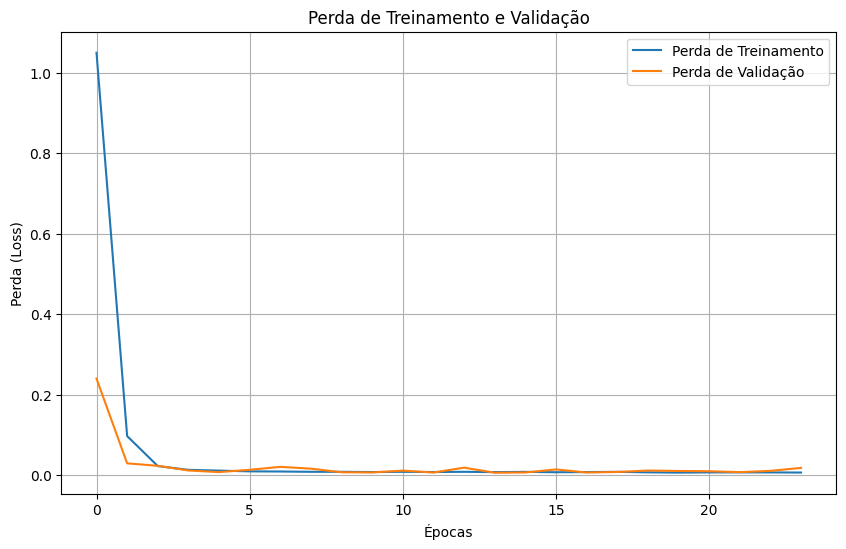

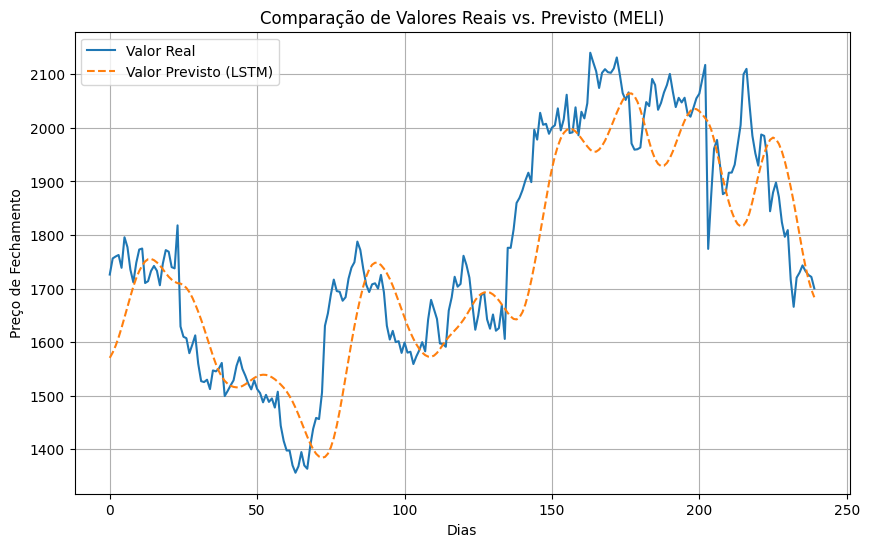

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
import math

# Carregar os dados históricos
symbol = 'MELI'  # Exemplo de símbolo
start_date = '2020-01-01'
end_date = '2025-01-01'
df = yf.download(symbol, start=start_date, end=end_date)

# Verificando se os dados foram baixados com sucesso
if df.empty:
    print(f"Nenhum dado encontrado para o símbolo {symbol} entre {start_date} e {end_date}.")
else:
    print("Dados baixados com sucesso.")

# Selecionar as colunas 'Close', 'Open', 'High', 'Low', 'Volume' para treino
df = df[['Close', 'Open', 'High', 'Low', 'Volume']]

# Normalizar os dados
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df)

# Criar as sequências para o modelo LSTM
sequence_length = 60
X, y = [], []

for i in range(sequence_length, len(df_scaled)):
    X.append(df_scaled[i-sequence_length:i, :])  # Usando todas as colunas
    y.append(df_scaled[i, 0])  # Prevendo a coluna 'Close'

X = np.array(X)
y = np.array(y)

# Mostrar as dimensões de X e y
print(f"Dimensões de X (dados de entrada): {X.shape}")  # (num_samples, sequence_length, num_features)
print(f"Dimensões de y (rótulos): {y.shape}")  # (num_samples,)

# Dividir os dados em treino e validação (80% treino, 20% validação)
train_size = int(len(X) * 0.8)
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

# Mostrar as dimensões de X_train e X_val
print(f"Dimensões de X_train: {X_train.shape}")
print(f"Dimensões de X_val: {X_val.shape}")

# Ajustar a forma dos dados para o LSTM (sequências de dados multivariados)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])  # (samples, time_steps, features)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2])  # (samples, time_steps, features)

# Mostrar as dimensões após o reshape
print(f"Dimensões de X_train após reshape: {X_train.shape}")
print(f"Dimensões de X_val após reshape: {X_val.shape}")

# ========================
# 1. Modelo LSTM Ajustado
# ========================
model_lstm = Sequential()
model_lstm.add(LSTM(units=150, return_sequences=True, input_shape=(sequence_length, X_train.shape[2]),
                    kernel_regularizer=l2(0.01)))  # L2 Regularization
model_lstm.add(Dropout(0.4))  # Dropout de 40%
model_lstm.add(LSTM(units=150, return_sequences=False, kernel_regularizer=l2(0.01)))  # L2 Regularization
model_lstm.add(Dropout(0.4))  # Dropout de 40%
model_lstm.add(Dense(units=1))  # Camada de saída
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Definir o callback de Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Treinamento do modelo LSTM com Early Stopping
history = model_lstm.fit(X_train, y_train, epochs=55, batch_size=15, validation_data=(X_val, y_val),
                         verbose=1, callbacks=[early_stopping])

# ============================
# 2. Avaliação do Modelo LSTM
# ============================
y_pred_lstm_scaled = model_lstm.predict(X_val)
print(f"Dimensões de y_pred_lstm_scaled (saída do modelo): {y_pred_lstm_scaled.shape}")

# Desnormalizar as previsões
y_pred_lstm = scaler.inverse_transform(np.concatenate((y_pred_lstm_scaled, np.zeros((y_pred_lstm_scaled.shape[0], X_val.shape[2]-1))), axis=1))[:, 0]
y_val_inv = scaler.inverse_transform(np.concatenate((y_val.reshape(-1, 1), np.zeros((y_val.shape[0], X_val.shape[2]-1))), axis=1))[:, 0]

# Métricas de Avaliação
mae_lstm = mean_absolute_error(y_val_inv, y_pred_lstm)
rmse_lstm = math.sqrt(mean_squared_error(y_val_inv, y_pred_lstm))
mape_lstm = np.mean(np.abs((y_val_inv - y_pred_lstm) / y_val_inv)) * 100

print(f"LSTM - MAE: {mae_lstm:.4f}, RMSE: {rmse_lstm:.4f}, MAPE: {mape_lstm:.4f}%")

# ============================
# 3. Gráficos de Desempenho
# ============================
# Gráfico da perda de treinamento e validação
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Perda de Treinamento')
plt.plot(history.history['val_loss'], label='Perda de Validação')
plt.title('Perda de Treinamento e Validação')
plt.xlabel('Épocas')
plt.ylabel('Perda (Loss)')
plt.legend()
plt.grid(True)
plt.show()

# Gráfico de comparação entre valores reais e previstos
plt.figure(figsize=(10, 6))
plt.plot(y_val_inv, label='Valor Real')
plt.plot(y_pred_lstm, label='Valor Previsto (LSTM)', linestyle='--')
plt.title(f'Comparação de Valores Reais vs. Previsto ({symbol})')
plt.xlabel('Dias')
plt.ylabel('Preço de Fechamento')
plt.legend()
plt.grid(True)
plt.show()


Resumo das Dimensões dos Tensores:
Entrada para o LSTM (X, X_train, X_val):
3 dimensões: (num_samples, sequence_length, num_features)
Saída do LSTM (y_pred_lstm_scaled):
2 dimensões: (num_samples, 1) (apenas uma variável predita, que é o 'Close').

Validação Cruzada (folds) - Redução de Overfiting

Baixando dados para o símbolo MELI de 2020-01-01 a 2024-01-01.
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Dados baixados com sucesso.

Iniciando Fold 1/5
Epoch 1/55
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 281ms/step - loss: 0.1110 - val_loss: 0.0019
Epoch 2/55
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 204ms/step - loss: 0.0067 - val_loss: 0.0014
Epoch 3/55
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 271ms/step - loss: 0.0043 - val_loss: 0.0015
Epoch 4/55
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 260ms/step - loss: 0.0042 - val_loss: 0.0017
Epoch 5/55
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 231ms/step - loss: 0.0043 - val_loss: 0.0013
Epoch 6/55
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 259ms/step - loss: 0.0042 - val_loss: 0.0012
Epoch 7/55
24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 334ms/step - loss: 0.0039 - val_loss: 0.0015
Epoch 8/55
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 364ms/step - loss: 0.0036 - val_loss: 0.0012
Epoch 9/55
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 241ms/step - loss: 0.0033 - val_loss: 0.0011
Epoch 10/55
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 334ms/step - loss: 0.0038 - val_loss: 0.0010
Epoch 11/55
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 281ms/step - loss: 0.0033 - val_loss: 0.0010


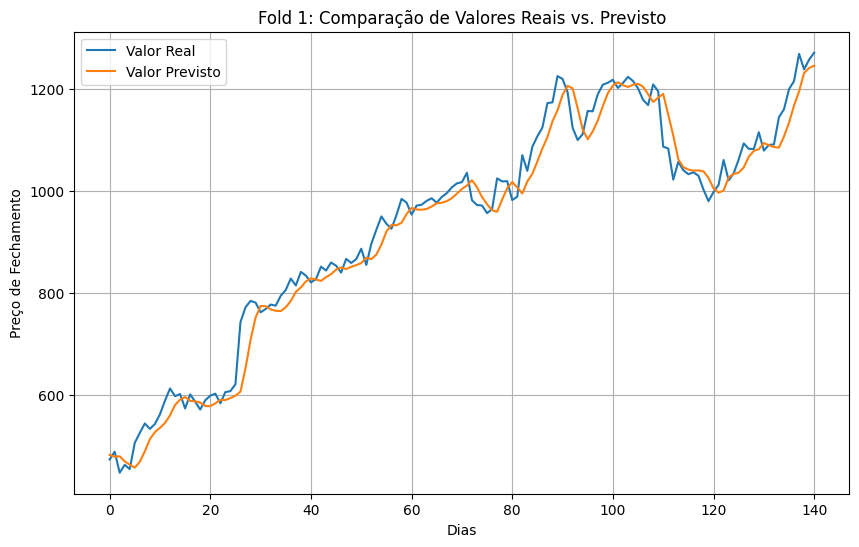


Iniciando Fold 2/5
Epoch 1/55


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 285ms/step - loss: 0.0479 - val_loss: 0.0060
Epoch 2/55
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 230ms/step - loss: 0.0045 - val_loss: 0.0050
Epoch 3/55
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 218ms/step - loss: 0.0047 - val_loss: 0.0034
Epoch 4/55
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 215ms/step - loss: 0.0039 - val_loss: 0.0034
Epoch 5/55
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 282ms/step - loss: 0.0040 - val_loss: 0.0030
Epoch 6/55
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 216ms/step - loss: 0.0037 - val_loss: 0.0028
Epoch 7/55
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 292ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 8/55
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 258ms/step - loss: 0.0031 - val_loss: 0.0033
Epoch 9/55
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 216ms/step - loss: 0.0029 - val_loss: 0.0024
Epoch 10/55
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 228ms/step - loss: 0.0028 - val_loss: 0.0049
Epoch 11/55
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 213ms/step - loss: 0.0034 - val_loss: 0.0023
Epoch 12/55
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 260ms/step - los

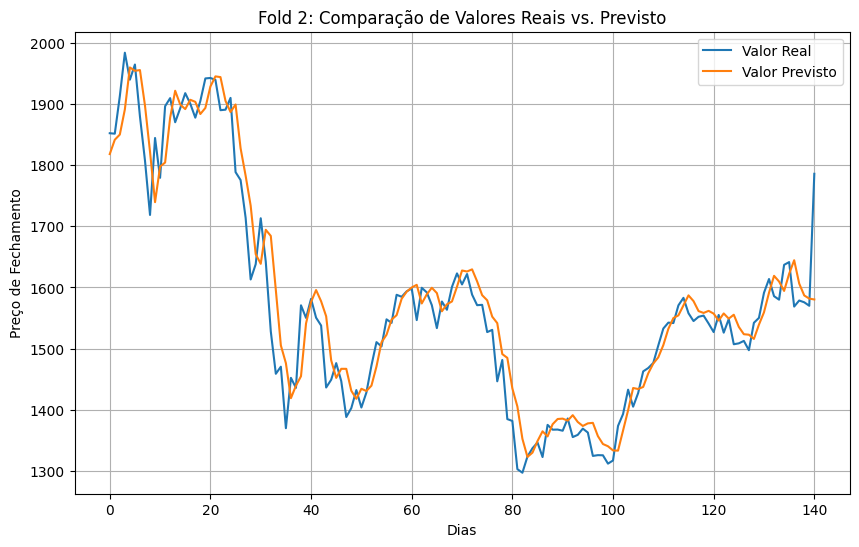


Iniciando Fold 3/5
Epoch 1/55


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 297ms/step - loss: 0.0811 - val_loss: 0.0057
Epoch 2/55
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 227ms/step - loss: 0.0081 - val_loss: 0.0060
Epoch 3/55
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 207ms/step - loss: 0.0050 - val_loss: 0.0054
Epoch 4/55
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 264ms/step - loss: 0.0039 - val_loss: 0.0045
Epoch 5/55
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 222ms/step - loss: 0.0047 - val_loss: 0.0042
Epoch 6/55
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 221ms/step - loss: 0.0050 - val_loss: 0.0041
Epoch 7/55
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 281ms/step - loss: 0.0041 - val_loss: 0.0061
Epoch 8/55
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 273ms/step - loss: 0.0048 - val_loss: 0.0040
Epoch 9/55
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 211ms/step - loss: 0.0032 - val_loss: 0.0037
Epoch 10/55
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 283ms/step - loss: 0.0036 - val_loss: 0.0037
Epoch 11/55
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 247ms/step - loss: 0.0030 - val_loss: 0.0040
Epoch 12/55
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 206ms/step - loss

4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


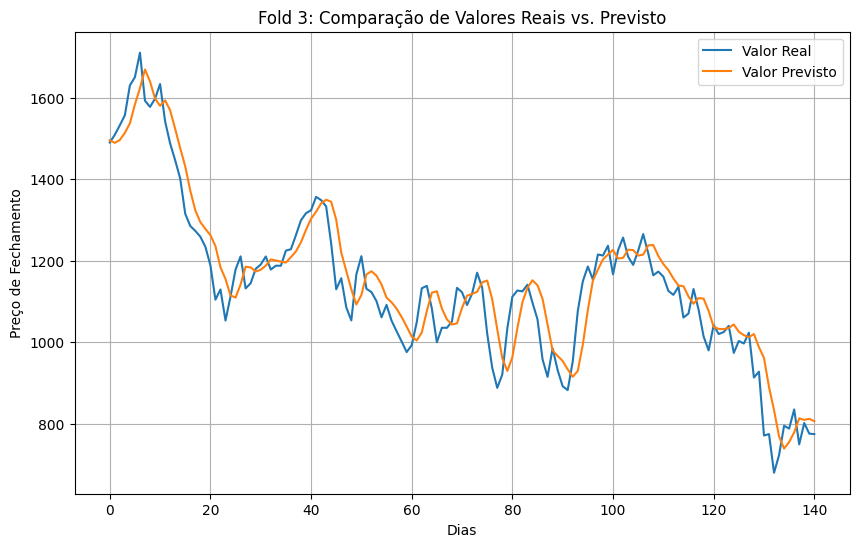


Iniciando Fold 4/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/55
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 256ms/step - loss: 0.0800 - val_loss: 0.0023
Epoch 2/55
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 274ms/step - loss: 0.0101 - val_loss: 0.0032
Epoch 3/55
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 214ms/step - loss: 0.0049 - val_loss: 0.0021
Epoch 4/55
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 294ms/step - loss: 0.0048 - val_loss: 0.0018
Epoch 5/55
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 234ms/step - loss: 0.0039 - val_loss: 0.0017
Epoch 6/55
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 260ms/step - loss: 0.0045 - val_loss: 0.0016
Epoch 7/55
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 294ms/step - loss: 0.0046 - val_loss: 0.0023
Epoch 8/55
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 215ms/step - loss: 0.0041 - val_loss: 0.0016
Epoch 9/55
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 216ms/step - loss: 0.0043 - val_loss: 0.0015
Epoch 10/55
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 227ms/step - loss: 0.0038 - val_loss: 0.0014
Epoch 11/55
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 272ms/step - loss: 0.0035 - val_loss: 0.0015
Epoch 12/55
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 212ms/

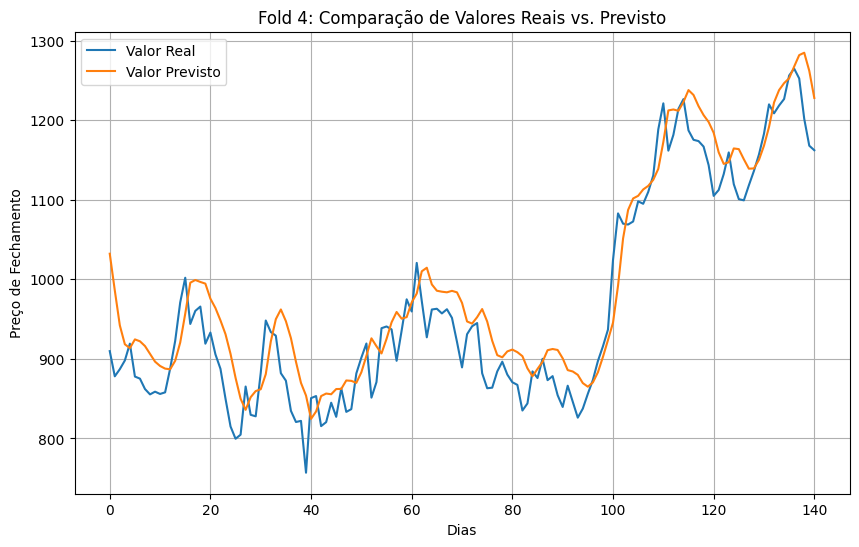


Iniciando Fold 5/5
Epoch 1/55


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 271ms/step - loss: 0.0711 - val_loss: 0.0036
Epoch 2/55
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 244ms/step - loss: 0.0049 - val_loss: 0.0034
Epoch 3/55
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 286ms/step - loss: 0.0050 - val_loss: 0.0022
Epoch 4/55
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 229ms/step - loss: 0.0047 - val_loss: 0.0018
Epoch 5/55
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 232ms/step - loss: 0.0035 - val_loss: 0.0022
Epoch 6/55
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 244ms/step - loss: 0.0042 - val_loss: 0.0018
Epoch 7/55
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 258ms/step - loss: 0.0039 - val_loss: 0.0029
Epoch 8/55
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 286ms/step - loss: 0.0043 - val_loss: 0.0020
Epoch 9/55
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 239ms/step - loss: 0.0031 - val_loss: 0.0016
Epoch 10/55
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 224ms/step - loss: 0.0037 - val_loss: 0.0020
Epoch 11/55
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 290ms/step - loss: 0.0037 - val_loss: 0.0039
Epoch 12/55
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 222ms/step - l

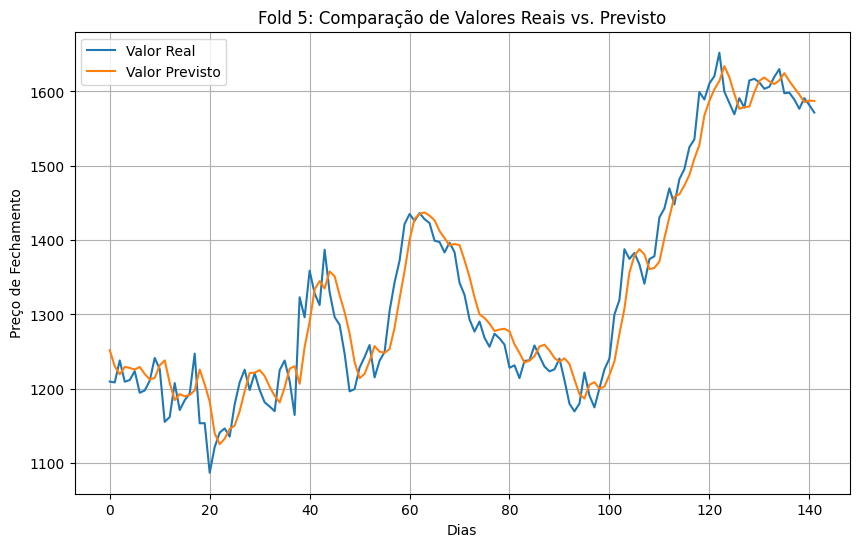


Métricas médias após validação cruzada:
MAE: 37.1892
RMSE: 47.6558
MAPE: 3.3733%


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
import matplotlib.pyplot as plt

# Parâmetros
symbol = 'MELI'  # Exemplo de símbolo
start_date = '2020-01-01'
end_date = '2024-01-01'
sequence_length = 60
n_splits = 5  # Número de divisões (folds)

# Baixar os dados históricos
print(f"Baixando dados para o símbolo {symbol} de {start_date} a {end_date}.")
df = yf.download(symbol, start=start_date, end=end_date)

# Verificando se os dados foram baixados com sucesso
if df.empty:
    print(f"Nenhum dado encontrado para o símbolo {symbol} entre {start_date} e {end_date}.")
else:
    print("Dados baixados com sucesso.")

dfr = df

# Selecionar apenas a coluna 'Close'
df = dfr[['Close']]

# Normalizar os dados
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df)

# Função para criar sequências para o modelo LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-sequence_length:i, 0])  # coluna Close
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Lista para armazenar as métricas
mae_scores = []
rmse_scores = []
mape_scores = []

# Implementação da validação cruzada com janela deslizante
step_size = len(df_scaled) // n_splits  # Divide os dados em n_splits

for fold in range(n_splits):
    print(f"\nIniciando Fold {fold + 1}/{n_splits}")

    # Determinar os índices de treino e validação
    val_start = fold * step_size
    val_end = (fold + 1) * step_size if fold != n_splits - 1 else len(df_scaled)

    train_data = np.concatenate((df_scaled[:val_start], df_scaled[val_end:]), axis=0)
    val_data = df_scaled[val_start:val_end]

    # Criar sequências para o treino e validação
    X_train, y_train = create_sequences(train_data, sequence_length)
    X_val, y_val = create_sequences(val_data, sequence_length)

    # Ajustar a forma dos dados para o LSTM
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

    # Criação do modelo LSTM
    model = Sequential()
    model.add(LSTM(units=150, return_sequences=True, input_shape=(sequence_length, 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=150, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Treinamento do modelo
    model.fit(X_train, y_train, epochs=55, batch_size=32, validation_data=(X_val, y_val), verbose=1)

    # Fazer previsões no conjunto de validação
    y_pred_scaled = model.predict(X_val)

    # Inverter a normalização para os valores previstos e reais
    y_pred = scaler.inverse_transform(y_pred_scaled)
    y_val_inv = scaler.inverse_transform(y_val.reshape(-1, 1))

    # Avaliar o modelo
    mae = mean_absolute_error(y_val_inv, y_pred)
    rmse = math.sqrt(mean_squared_error(y_val_inv, y_pred))
    mape = np.mean(np.abs((y_val_inv - y_pred) / y_val_inv)) * 100

    # Armazenar as métricas de avaliação para o fold atual
    mae_scores.append(mae)
    rmse_scores.append(rmse)
    mape_scores.append(mape)

    # Exibir os gráficos de comparação entre valores reais e previstos para este fold
    plt.figure(figsize=(10, 6))
    plt.plot(y_val_inv, label='Valor Real')
    plt.plot(y_pred, label='Valor Previsto')
    plt.title(f'Fold {fold + 1}: Comparação de Valores Reais vs. Previsto')
    plt.xlabel('Dias')
    plt.ylabel('Preço de Fechamento')
    plt.legend()
    plt.grid(True)
    plt.show()

# Exibir as métricas médias de avaliação para todos os folds
print("\nMétricas médias após validação cruzada:")
print(f"MAE: {np.mean(mae_scores):.4f}")
print(f"RMSE: {np.mean(rmse_scores):.4f}")
print(f"MAPE: {np.mean(mape_scores):.4f}%")